# Machine Learning Engineer Nanodegree
## Unsupervised Learning
## Project 3: Creating Customer Segments

Welcome to the third project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [123]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import renders as rs
from IPython.display import display # Allows the use of display() for DataFrames

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

In [124]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,10850,7555,14961,188,6899,46
1,6202,7775,10817,1183,3143,1970
2,23257,1372,1677,982,429,655


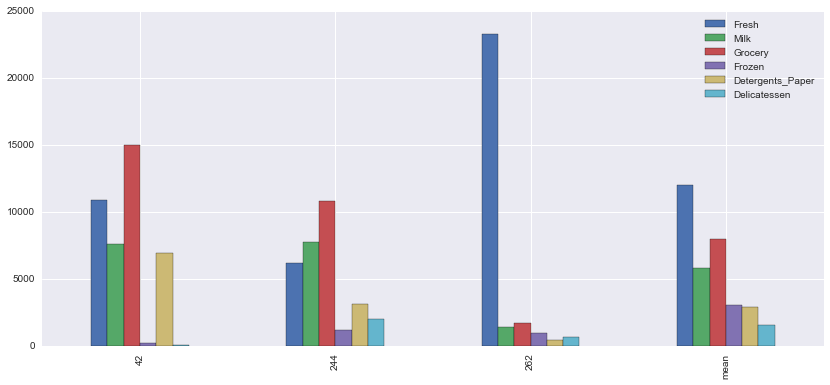

In [125]:
# TODO: Select three indices of your choice you wish to sample from the dataset
indices = [42,244,262]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)

# From Review: Import Seaborn, a very powerful library for Data Visualisation
import seaborn as sns
# plot bar graph of samples and mean
samples_bar = samples.append(data.describe().loc['mean'])
samples_bar.index = indices + ['mean']
_ = samples_bar.plot(kind='bar', figsize=(14,6))



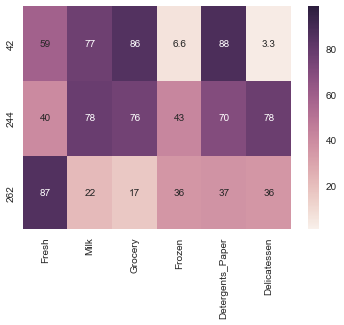

In [126]:
# From Review: Plot heat map
# First, calculate the percentile ranks of the whole dataset.
percentiles = data.rank(pct=True)
# Then, round it up, and multiply by 100
percentiles = 100*percentiles.round(decimals=3)
# Select the indices you chose from the percentiles dataframe
percentiles = percentiles.iloc[indices]
# Now, create the heat map using the seaborn library
_ = sns.heatmap(percentiles, vmin=1, vmax=99, annot=True)

### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  
*What kind of establishment (customer) could each of the three samples you've chosen represent?*  
**Hint:** Examples of establishments include places like markets, cafes, and retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant.

**Answer:**

1. The first customer (index 42) needs roughly average Fresh, lots of Milk, Grocery, and Detergents_Paper, but very little Frozen and Delicatessen. This might represent an outdoor (street) market, which has only very limited capacity to freeze things, or a (specialized) restaurant.
2. The second customer (index 244) buys roughly average of everything, only a little more Milk and Grocery. It seems plausible that this might represent a larger cafe or restaurant.
3. The third customer (index 262) buys a lot of Fresh products (first quartile) but below average for the other products (always third or fourth quartile, respectively). So this might indicate a retailer market (specializing on fresh products).



### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [127]:
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor

chosen_feat = 'Milk'

# TODO: Make a copy of the DataFrame, using the 'drop' function to drop the given feature
new_data = data.copy()
new_data.drop([chosen_feat], axis = 1, inplace = True)

# TODO: Split the data into training and testing sets using the given feature as the target
X_train, X_test, y_train, y_test = train_test_split(new_data, data[chosen_feat], test_size=0.25, random_state=442)

# TODO: Create a decision tree regressor and fit it to the training set
regressor = DecisionTreeRegressor(random_state=442)
regressor.fit(X_train, y_train)

# TODO: Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)
print score



0.630631709911


### Question 2
*Which feature did you attempt to predict? What was the reported prediction score? Is this feature is necessary for identifying customers' spending habits?*  
**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data.

**Answer:**

I choose the feature "Milk" as I suspected that milk might be considered as "Fresh" product anyway. 
The reported predicition score is 0.63. Therefore I would say that we can predict the "Milk" consumption quite well from the remaining data, but still there seems to be some additional information that we would throw away if the feature "Milk" was ignored in the model. If there are no other significant reasons to skip "Milk", I'd say let's keep it.


### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

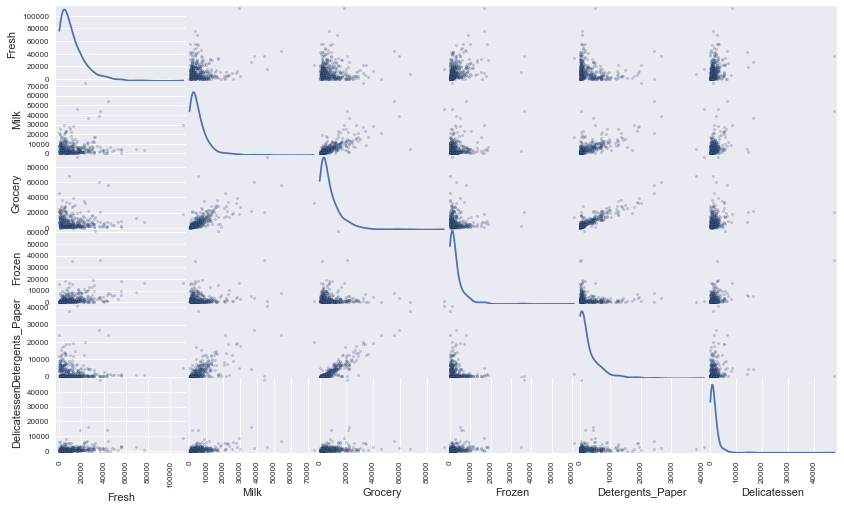

In [128]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Question 3
*Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? How is the data for those features distributed?*  
**Hint:** Is the data normally distributed? Where do most of the data points lie? 

**Answer:**

The above scatter matrix definitely shows different degrees of correlation between features. 

On the bottom end, I would say that Delicatessen are not strongly correlated to any other feature (and that's why running the Regressor in the "Feature Relevance" section gets a prediction score close to 0 when trying to predict "Delicatessen" from the remaining features).

To the naked eye, the clearest example of a strong correlation is between "Detergents_Paper" and "Grocery". 

Regarding the feature "Milk", which I tried to predict, there seems to be some correlation with "Detergents_Paper" and with "Grocery", while apparently it is quite independent from the other features. An interesting relation appears between Milk and Fresh: From the scatterplot it almost looks like there is a correlation between them, but a negative one (i.e. when a customer buys a lot of Milk, he will rather buy little Fresh, and vice versa). Let's try to figure that out (apparently, this is a pandas one-liner - see below).

The diagonal of the scatts plot matrix shows that all features have a distribution with substantial positive skew (the mass of the distribution is concentrated at the left of the figure, the right tail is very long). This should be corrected by a suitable normalization to obtain a normally distributed data set (for clustering) - see below scatter plot using the natural logarithm for each data feature.

In [129]:
data.corr()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Fresh,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicatessen,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


As seen in the scatter matrix, the correlation between Detergents_Paper and Grocery is very high (0.92). Delicatessen is only weakly correlated with other features (between 0.07 and 0.41). The correlation between Milk and Fresh is indeed *positive*, although quite close to 0.

Note that most correlations are positive, and no correlations are "very" negative (minimum is -0.13 between Detergents_Paper and Frozen).

## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying a logarithm scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying a logrithm scaling. Again, use `np.log`.

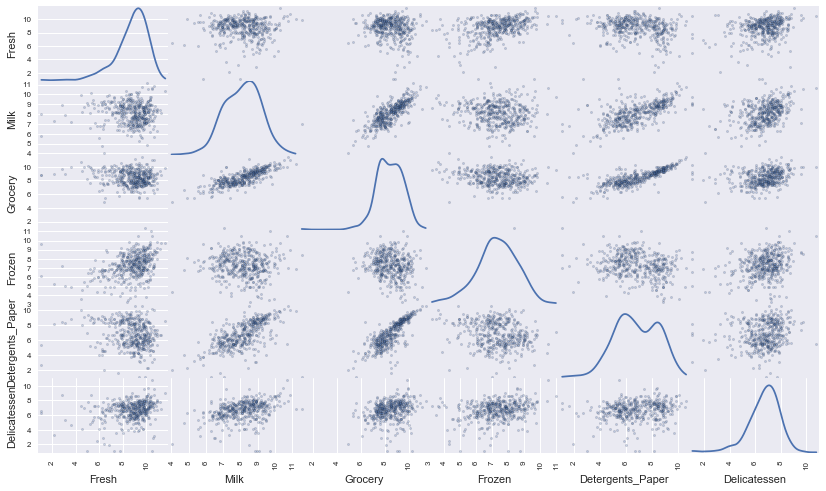

In [130]:
# TODO: Scale the data using the natural logarithm
log_data = np.log(data.copy())

# TODO: Scale the sample data using the natural logarithm
log_samples = np.log(samples.copy())

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

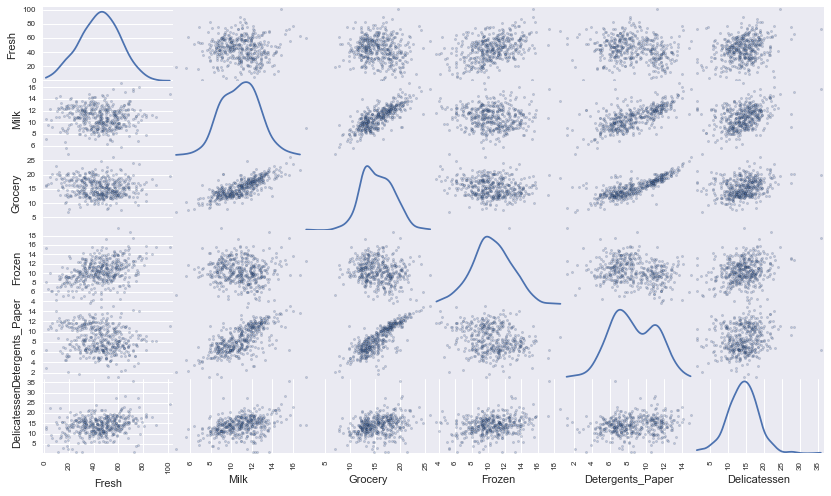

In [131]:
# For fun, let's do a Box Cox Test on the sample data:
from scipy.stats import boxcox

bc_data = data.copy()
for feat in bc_data.columns:
    bc_data[feat] = boxcox(bc_data[feat])[0]
pd.scatter_matrix(bc_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');


The above scatter plot for the Box Cox data shows even better results in terms of obtaining "normally distributed" data.


### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [132]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,9.291920,8.929965,9.613202,5.236442,8.839132,3.828641
1,8.732627,8.958669,9.288874,7.075809,8.052933,7.585789
2,10.054361,7.224025,7.424762,6.889591,6.061457,6.484635


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


The data points with these indices are outliers in more than one feature:
Int64Index([65, 66, 75, 128, 154], dtype='int64')

Extreme outliers:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
338,1.098612,5.808142,8.856661,9.655090,2.708050,6.309918


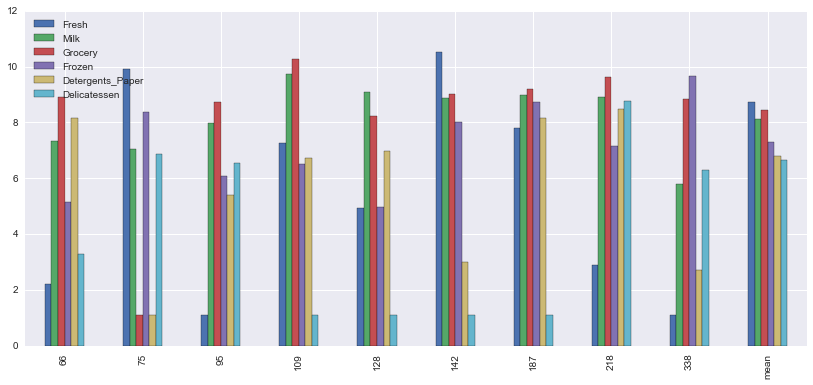

In [133]:
outlier_indices = []
extr_outlier_df = pd.DataFrame()
common_outlier_index = pd.DataFrame().index

# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature],25)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature],75)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5 * (Q3 - Q1)
    
    # according to the description of Tukey's method, the "extreme" outliers can be identified with a factor of 3 to the IQR:
    extreme_step = 3.0 * (Q3 - Q1)
    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    outlier_df = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    display(outlier_df)
    
    # Collect extreme outliers
    extr_outlier_df = extr_outlier_df.add(log_data[~((log_data[feature] >= Q1 - extreme_step) \
                                 & (log_data[feature] <= Q3 + extreme_step) )]\
                        ,fill_value=0\
                       )

    # Note whether any outlier data points were already identified as outliers in previous features
    for previous_indices in outlier_indices:
        common_outlier_index = common_outlier_index.union(outlier_df.index.intersection(previous_indices))
    outlier_indices.append(outlier_df.index)

# Display multiple outliers
print "The data points with these indices are outliers in more than one feature:"
print common_outlier_index
print

# Display extreme outliers + plot bar graphs
print "Extreme outliers:"
display(extr_outlier_df)
extr_outlier_bar = extr_outlier_df.append(log_data.describe().loc['mean'])
extr_outlier_bar.index.union(['mean'])
_ = extr_outlier_bar.plot(kind='bar', figsize=(14,6))

# OPTIONAL: Select the indices for data points you wish to remove
outliers  = []

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

### Question 4
*Are there any data points considered outliers for more than one feature based on the definition above? Should these data points be removed from the dataset? If any data points were added to the `outliers` list to be removed, explain why.* 

**Answer:**

There are five data points that can be considered outliers based on more than one feature: 65, 66, 75, 128, 154. 

Also, there are nine data points that are "extreme" outliers, i.e. they are more than 3 IQR's away from the median 50%: 66, 95, 218, 338, 75, 109, 128, 142, 187. Just by looking at the bar plot of these extreme outliers, we can tell that for each of them, a certain product type was bought by the customer in an unusually low quantity - but there is no indication that anything is wrong with the data!

*The above analysis does not justify removal of any (outlier) data points. Removing outliers in the present case rather seems to have the potential to throw away interesting information. *


## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

Dimension 1    0.4424
Dimension 2    0.7190
Dimension 3    0.8352
Dimension 4    0.9314
Dimension 5    0.9772
Dimension 6    1.0001
Name: Explained Variance, dtype: float64


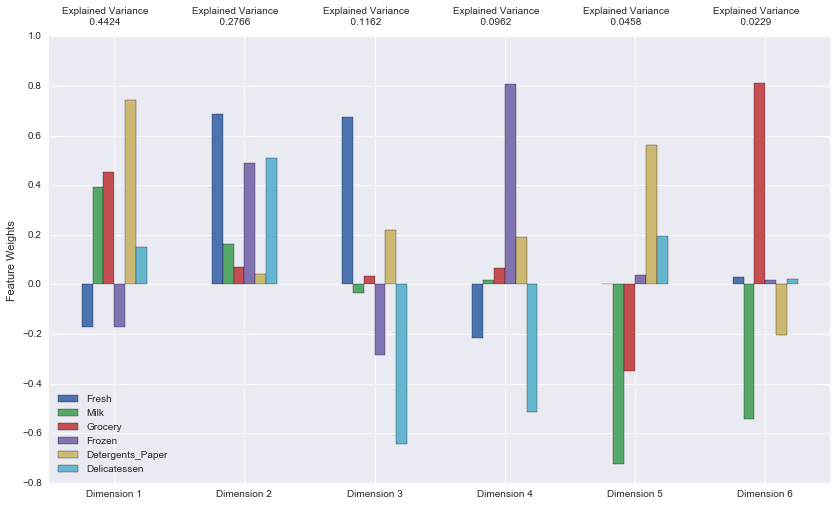

In [134]:
from sklearn.decomposition import PCA

# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=6)
pca.fit(good_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = rs.pca_results(good_data, pca)

print pca_results['Explained Variance'].cumsum()

### Question 5
*How much variance in the data is explained* ***in total*** *by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the indivdual feature weights.

**Answer:**

The 1st and 2nd principal components explain 71.9% of the variance in the data.

The first four principal components explain 93.1% of the variance in the data.


Using the above visualization, the first four dimensions represent:
1. The observation that customers who buy lots of Detergents_Paper also buy more Milk and Grocery than average (and vice versa). This dimension should be higher for Retailers / Markets than for Cafes / Restaurants.
2. Customers who buy lots of (few) Fresh also buy lots of (few) Frozen and Delicatessen - and vice versa. This is relatively independent of the amount of other products bought. This could be related mainly to the size of the customer. 
3. Those who buy more Delicatessen than average buy less Fresh than average, and vice versa. Maybe cafes should score higher here than restaurants.
4. In addition to all the things said before, there are some customers who buy more Delicatessen and less Fresh and some customers who buy more Fresh and less Delicatessen.


### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [135]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,2.2165,-1.7695,3.2537,0.1525,-0.4634,0.0147
1,1.8362,0.6086,-0.2517,-0.3440,-0.0142,-0.0042
2,-1.5418,0.3676,0.9641,-0.7429,0.5441,-0.1660


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the reuslts to `reduced_data`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [136]:
# TODO: Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2)
pca.fit(good_data)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [137]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,2.2165,-1.7695
1,1.8362,0.6086
2,-1.5418,0.3676


## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6
*What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*

**Answer:**

*K-Means* is easy and gives a clear answer (hard clustering). It is simple, robust, and fast (see https://sites.google.com/site/dataclusteringalgorithms/k-means-clustering-algorithm). One drawback is that K-Means needs an initial position for any cluster center - and depending on these initial positions K-Means may end up in a local minimum.

The *Gaussian Mixture Model* is more complex (and contains K-Means) - but also more subtle and may more faithfully reflect the ambiguity in clustering (soft clustering). GMM obtains a density estimate for each cluster in order to cover the data well (see http://home.deib.polimi.it/matteucc/Clustering/tutorial_html/mixture.html). One data point is not either A or B, but partly A, partly B. GMM is quite fast for a learning mixture model (see http://scikit-learn.org/stable/modules/mixture.html#gmm-classifier), but it is slower than K-Means.


I choose to use the K-Means algorithm, as I feel it is paramount to produce a graspable and clear approach to clustering. The origin of the data also motivates the assumption that a customer is of a specific category (there are typically no hybrids like "retailer restaurants"). 

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import sklearn.metrics.silhouette_score and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [138]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

for num_clus in [2]:
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = KMeans(n_clusters=num_clus, random_state=442)
    clusterer.fit(reduced_data)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # TODO: Find the cluster centers
    centers = clusterer.cluster_centers_
    #print centers

    # TODO: Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds)
    print "Mean silhouette score with {} clusters: {:.3f}".format(num_clus, score)

Mean silhouette score with 2 clusters: 0.419


### Question 7
*Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score?* 

**Answer:**

Mean silhouette score with 2 clusters: 0.419

Mean silhouette score with 3 clusters: 0.392

Mean silhouette score with 4 clusters: 0.330

Mean silhouette score with 5 clusters: 0.350

Mean silhouette score with 6 clusters: 0.353

Mean silhouette score with 7 clusters: 0.355

Mean silhouette score with 8 clusters: 0.356

Mean silhouette score with 9 clusters: 0.352

Mean silhouette score with 10 clusters: 0.354


**The best silhouette score is obtained with only 2 clusters.**

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

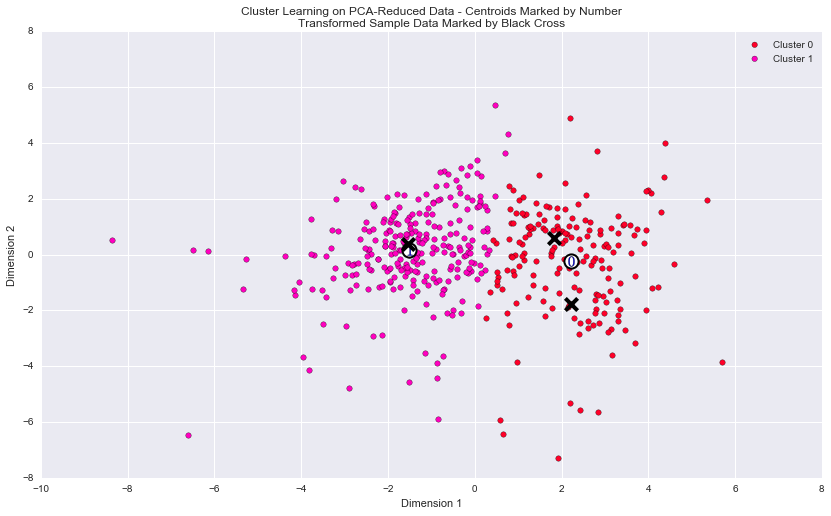

In [139]:
# Display the results of the clustering from implementation
rs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,3570.0,7749.0,12463.0,900.0,4567.0,966.0
Segment 1,8994.0,1909.0,2366.0,2081.0,290.0,681.0


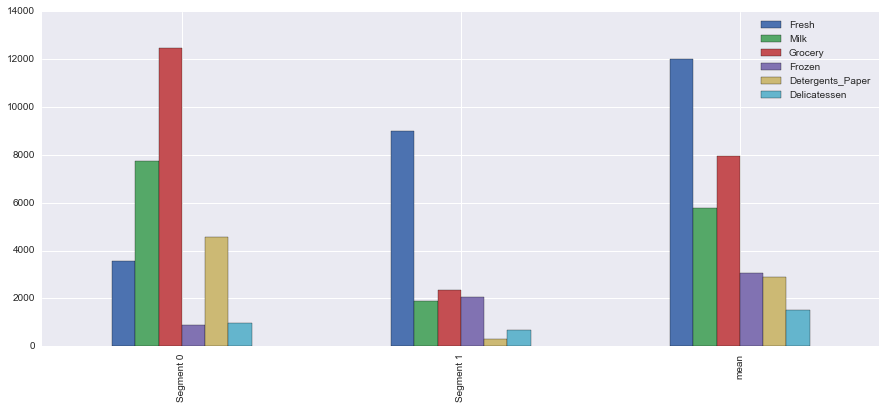

In [140]:
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

# From Review: Create bar plot including both segment center points and mean
true_centers = true_centers.append(data.describe().loc['mean'])
_ = true_centers.plot(kind='bar', figsize=(15,6))


### Question 8
Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. *What set of establishments could each of the customer segments represent?*  
**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`.

**Answer:**

Segment 0 could represent a **cafe or restaurant**:
This "typical" customer buy less than average Fresh, Frozen, and Delicatessen, and above average Milk, Grocery, and Detergents_Paper (for cleaning the restaurant). It seems that there is no product category for which this customer does not buy at least something (i.e. for all product categories consumption is in the third quartile or higher). I suppose this means that this customer type needs lots of different things to offer to its clients and to run its business, which seems typical for a cafe or restaurant (or hotel) business.


Segment 1 could represent a **(retailer) market**:
This "typical" customer buys first and foremost Fresh products - all other products types are below average. Hardly any detergents and paper are bought, also only little milk and delicatessen. This indicates an establishment that has somehow specialized on one product category and has little need to clean up or to offer a broader palette of products to its customers. This appears typical for a market or retailer, and not for a cafe/restaurant, or hotel.

### Question 9
*For each sample point, which customer segment from* ***Question 8*** *best represents it? Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [141]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred

Sample point 0 predicted to be in Cluster 0
Sample point 1 predicted to be in Cluster 0
Sample point 2 predicted to be in Cluster 1


**Answer:**

Buy looking at the consumption data for sample points and for the Segments 0 and 1 (and also at the bar graphs for all), we can conclude the following:

Sample point 0 with its high Milk, Grocery, and Detergents_Paper values (green, red, and yellow in the plot) is clearly similar to Segment 0 - and not to Segment 1. Hence, it should represent a bar or restaurant. Fresh is also quite high (blue), but this is not so strikingly high as to suggest that Segment 1 is more appropriate.

Sample point 1 looks even more similar to the center point for Segment 0. It clearly belongs to this customer segment.

In contrast to that, sample point 2 is decidedly similar to the center point for segment 1: A very high "Fresh" value (blue) towering far above all the other product types. Most certainly, it corresponds to a customer in segment 1, i.e. it represents a retailer / market.

*All discussed categorizations are consistent with the predictions by the model.*



In my discussion of the possible nature of the sample points (Question 1), I was unsure about sample 0 (index 42), oscillating between "street market" and "specialized restaurant". With the above analysis done, it becomes very clear which category this sample belongs to.

The other two sample points have the classification that I expected in my intial discussion ("cafe/restaurant" for sample 2, "(retailer) market" for sample 3).

## Conclusion

In this final section, you will investigate ways that you can make use of the clustered data. First, you will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, you will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, you will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Question 10
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. *How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?*  
**Hint:** Can we assume the change affects all customers equally? How can we determine which group of customers it affects the most?

**Answer:**

It is fair to assume that customers in Segment 0 will potentially be affected in a different manner than customers from Segment 1 by the planned change.

We could speculate about the effect that the change might have by reasoning (i.e. How fresh do fresh products have to be in a market or a restaurant? How well can a market or restaurant plan what goods it needs? ...).

Even better is it to A/B-test the intended change with a sample of "restaurant" customers and a sample of "market" customers. The effect on each of these sample groups can then be assessed independently. Any further decision on whether and how to implement this change can then be based on the test results.





### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
*How can the wholesale distributor label the new customers using only their estimated product spending and the* ***customer segment*** *data?*  
**Hint:** A supervised learner could be used to train on the original customers. What would be the target variable?

**Answer:**

A supervised learner could be trained to predict the *customer segment* - i.e. the *customer segment* is used as a label for the data available at the moment.

If the only information on a new customer is the (expected) product spending, this is a reasonable approach. (In the real world, presumably it will be not too hard to determine whether a customer is a restaurant or a retailer market.)

Looking at the below scatter plot, we can assume that the classification of new customers based on the customer segment data will be quite successful.


### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

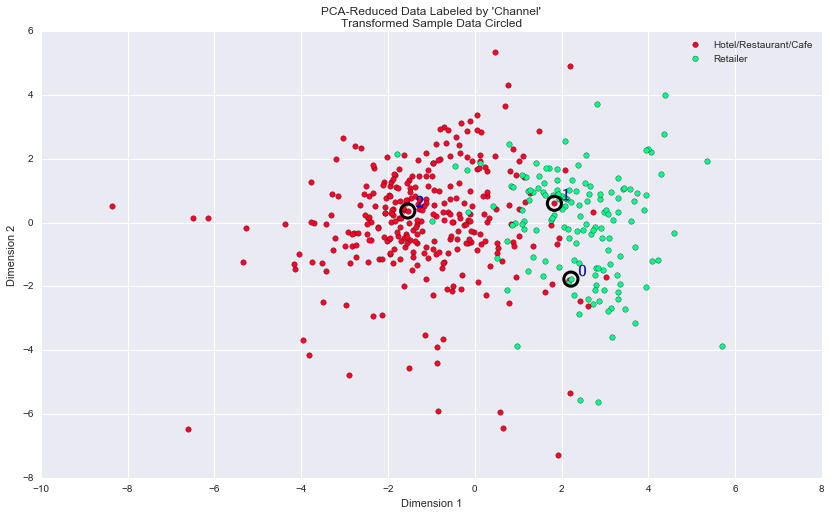

In [142]:
# Display the clustering results based on 'Channel' data
rs.channel_results(reduced_data, outliers, pca_samples)

### Question 12
*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? Would you consider these classifications as consistent with your previous definition of the customer segments?*

**Answer:**

In my analysis there are two clusters, which is compatible with the given labeling as either 'HoReCa' or 'Retail'. The suggested meaning of of the two segments also are consistent with the categorization in the 'Channel' data - "Cafe/Restaurant" corresponds to "HoReCa", and "(Retailer) Market" matches "Retailer".

Looking at the scatter plot I find that for most data points, the determined segment matches the 'channel' label as present in the data. Anyhow, there are several data points which are apparently not correctly attributed to customer segments. Their location in the plot suggests that the reduction of the data to two components may have taken too much information away (as it's clearly not a flaw in the clusterer K-Means that has somehow gotten the clustering wrong). Also, there really might be some restaurants that have a product spending pattern that is rather typical for retailers - and vice versa.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.